# **Redes Neuronales Profundas Utilizando Keras**

En este cuaderno (Laboratorio 3) vamos a explorar como crear redes neuronales utilizando la API de tensorflow Keras, teniendo en cuenta lo visto en las lecciones del curso [Deep Learning y Redes Neuronales](https://).

## **Objetivos**

* Implementar una red neuronal profunda utilizando Keras para la classificación de imagenes (Deteccion de si una imagen es un gato o no).
* Comprender algunos conceptos para el preprocesamiento de los datos.
* Implementar un modelo utilizando la clase [Sequential](https://keras.io/api/models/sequential/) de Keras.
* Comprender como entrenar el modelo utilizando Keras.

Para comenzar importaremos algunas liberias utilizadas para la implementación del modelo. 

In [45]:
import matplotlib.pyplot as plt
import numpy as np
import h5py

from keras import Sequential
from keras.layers import InputLayer, Dense
from keras.optimizers import SGD
from keras import datasets

Luego de importar las librerias necesarias, vamos a cargar el dataset a nuestro Notebook.

In [46]:
# Definimos una funcion para cargar los datasets
def loadData():
    train_dataset = h5py.File("train_catvnoncat.h5", "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # Caracteristicas del set de entrenamiento
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # Etiquetas del set de entrenamiento

    test_dataset = h5py.File("test_catvnoncat.h5", "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # Caracteristicas del set de prueba
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # Etiquetas del set de prueba

    classes = np.array(test_dataset["list_classes"][:]) # Lista de clases
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

Ya definida la función cargamos los datos de entrenamiento y prueba.

In [47]:
X_train, Y_train, X_test, Y_test, classes = loadData() # Cargamos los datos

Exploramos las dimensiones de nuestros sets de entrenamiento y prueba para tener una mejor comprensión sobre ellos.

In [48]:
# Exploramos el tamaño de nuestras variables
m_train = X_train.shape[0]
num_px = X_train.shape[1]
m_test = X_test.shape[0]

print ("Numero de ejemplos de entrenamiento: m = " + str(m_train))
print ("Numero de ejemplos de prueba: " + str(m_test))
print ("Tamaño de cada imagen: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("Tamaño de X_train: " + str(X_train.shape))
print ("Tamaño de Y_train: " + str(Y_train.shape))
print ("Tamaño de X_test: " + str(X_test.shape))
print ("Tamaño de Y_test: " + str(Y_test.shape))

Numero de ejemplos de entrenamiento: m = 209
Numero de ejemplos de prueba: 50
Tamaño de cada imagen: (64, 64, 3)
Tamaño de X_train: (209, 64, 64, 3)
Tamaño de Y_train: (1, 209)
Tamaño de X_test: (50, 64, 64, 3)
Tamaño de Y_test: (1, 50)


Visualizamos uno de los ejemplos de entrenamientos junto con su etiqueta correspondiente. Para vizualizar otras imagenes simplemente basta con cambiar la variable indice.

y = 0 -> non-cat


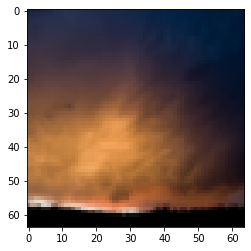

In [49]:
# Mostramos una de la imagenes del dataset
indice = 0 # Cambiar el numero para ver otras imagenes
plt.imshow(X_train[indice])
print ("y = " + str(Y_train[0,indice]) + " -> " + classes[Y_train[0,indice]].decode("utf-8"))

## Preprocesamiento

Una parte importante en la implementación de redes neuronales es el preprocesamiento de los datos antes de comenzar el entrenamiento. Puesto a que estamos trabajndo con imagenes, cada uno de los ejemplos es un arreglo de 3 dimensiones correspondientes a los 3 canales RGB en la imagen, sin embargo, la red neuronal no recibe como entrada un arreglo de 3 dimensiones sino que por cada ejemplo recibe un arreglo de una sola dimensión. Por este motivo es necesario reestructurar las dimensiones de los sets de entrenamiento y prueba.

Para esto se realizan los siguientes pasos en este caso particular:

1. Se aplanan cada uno de los ejemplos de entrenamiento. De modo que si cada ejemplo era un arreglo de 3 dimensiones (n, n, 3), luego de ser aplanado cada ejemplo sera (n x n x 3, 1). En este caso cada imagen en los sets es de tamaño (64, 64, 3), luego de aplanarlas seran (64x64x3, 1) = (12288, 1). El tamaño total de los sets sera (12288, m), siendo m el numero de ejemplos.
2. Luego de aplanar los ejemplos es necesario trasponer los sets para que queden de un tamaño (m, 12288), ya que Keras siempre recibe como entrada un arreglo de tamaño (m, $n_x$).
3. Por ultimo es necesario normalizar los datos para que todos queden entre 0 y 1, esto si bien no es obligatorio, ayuda en gran manera a acelerar el aprendizaje de la red neuronal y a evitar algunos problemas. Para normalizar los datos basta con dividirlos por el maximo valor presente en el set, en este caso el maxim valor para un pixel en una imagen es 255, por esta razon los datos se dividen por 255.

In [50]:
# Cambiamos el tamaño de los ejemplos de prueba y de entrenamiento para que sean un vector plano 
X_train_flatten = X_train.reshape(X_train.shape[0], -1)   # El "-1" hace que la función reshape aplane el resto de dimensiones
X_test_flatten = X_test.reshape(X_test.shape[0], -1)
Y_train = Y_train.T
Y_test = Y_test.T

# Normalizar los valores para que todos esten entre 0 y 1
train_x = X_train_flatten/255.
test_x = X_test_flatten/255.

print ("Tamaño de train_x: " + str(train_x.shape))
print ("Tamaño de test_x: " + str(test_x.shape))
print ("Tamaño de Y_train: " + str(Y_train.shape))
print ("Tamaño de Y_test: " + str(Y_test.shape))

Tamaño de train_x: (209, 12288)
Tamaño de test_x: (50, 12288)
Tamaño de Y_train: (209, 1)
Tamaño de Y_test: (50, 1)


Con nuestros datos listos procedemos a definir las capas de nuestro modelo y luego crearlo utilizando la clase de Keras [Sequential](https://keras.io/api/models/sequential/).

In [51]:
# Definimos nuestro modelo

# Definimos las capas de nuestro modelo
input = InputLayer(input_shape=(train_x.shape[1],))
capa1 = Dense(units=16, activation="relu", name="Capa_1")
capa2 = Dense(units=8, activation="relu", name="Capa_2")
capa3 = Dense(units=4, activation="relu", name="Capa_3")
salida = Dense(units=1, activation="sigmoid", name="Salida")

# Creamos el modelo con la clase Sequential
modelo = Sequential([
  input,
  capa1,
  capa2,
  capa3,
  salida
])

# Imprimos el resumen de la arquitectura de nuestro modelo
modelo.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Capa_1 (Dense)              (None, 16)                196624    
                                                                 
 Capa_2 (Dense)              (None, 8)                 136       
                                                                 
 Capa_3 (Dense)              (None, 4)                 36        
                                                                 
 Salida (Dense)              (None, 1)                 5         
                                                                 
Total params: 196,801
Trainable params: 196,801
Non-trainable params: 0
_________________________________________________________________


Una vez creado el modelo simplemente basta con definir nuestro algoritmo de optimizacion, compilar el modelo con la configuracion para el entrenamiento y comenzar a entrenarlo.

Epoch 1/2500
1/1 [==============================] - 0s 463ms/step - loss: 0.6893 - accuracy: 0.5215
Epoch 2/2500
1/1 [==============================] - 0s 16ms/step - loss: 0.6829 - accuracy: 0.5981
Epoch 3/2500
1/1 [==============================] - 0s 19ms/step - loss: 0.6744 - accuracy: 0.6364
Epoch 4/2500
1/1 [==============================] - 0s 16ms/step - loss: 0.6605 - accuracy: 0.6555
Epoch 5/2500
1/1 [==============================] - 0s 18ms/step - loss: 0.6468 - accuracy: 0.6555
Epoch 6/2500
1/1 [==============================] - 0s 20ms/step - loss: 0.6443 - accuracy: 0.6555
Epoch 7/2500
1/1 [==============================] - 0s 18ms/step - loss: 0.6423 - accuracy: 0.6555
Epoch 8/2500
1/1 [==============================] - 0s 19ms/step - loss: 0.6404 - accuracy: 0.6555
Epoch 9/2500
1/1 [==============================] - 0s 20ms/step - loss: 0.6386 - accuracy: 0.6555
Epoch 10/2500
1/1 [==============================] - 0s 16ms/step - loss: 0.6367 - accuracy: 0.6555
Epoch 11

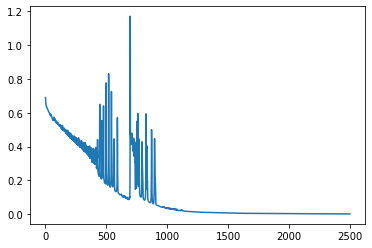

In [52]:
# Definimos el algoritmo de optimización, en este caso es gradiente descendente
optimizer = SGD(learning_rate=0.01)

# Compilamos el modelo estableciendo el metodo de optimizacion, funcion de costo, y metricas de desempeño
modelo.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

# Entrenamos el modelo pasando nuestro datos de entrenamiento
history = modelo.fit(train_x, Y_train, epochs=2500, batch_size=train_x.shape[0])

plt.plot(history.history["loss"])
plt.show()

Una vez entrenado verificamos tanto la exactitud sobre el set de entrenamiento como la exactitud sobre el set de prueba.

In [53]:
print("Exactitud en el entrenamiento: " + str(history.history["accuracy"][-1]))

loss, acc = modelo.evaluate(test_x, Y_test)
print("Exactitud en el dataset de prueba: "+ str(acc))

Exactitud en el entrenamiento: 1.0
2/2 [==============================] - 0s 6ms/step - loss: 1.4670 - accuracy: 0.7400
Exactitud en el dataset de prueba: 0.7400000095367432


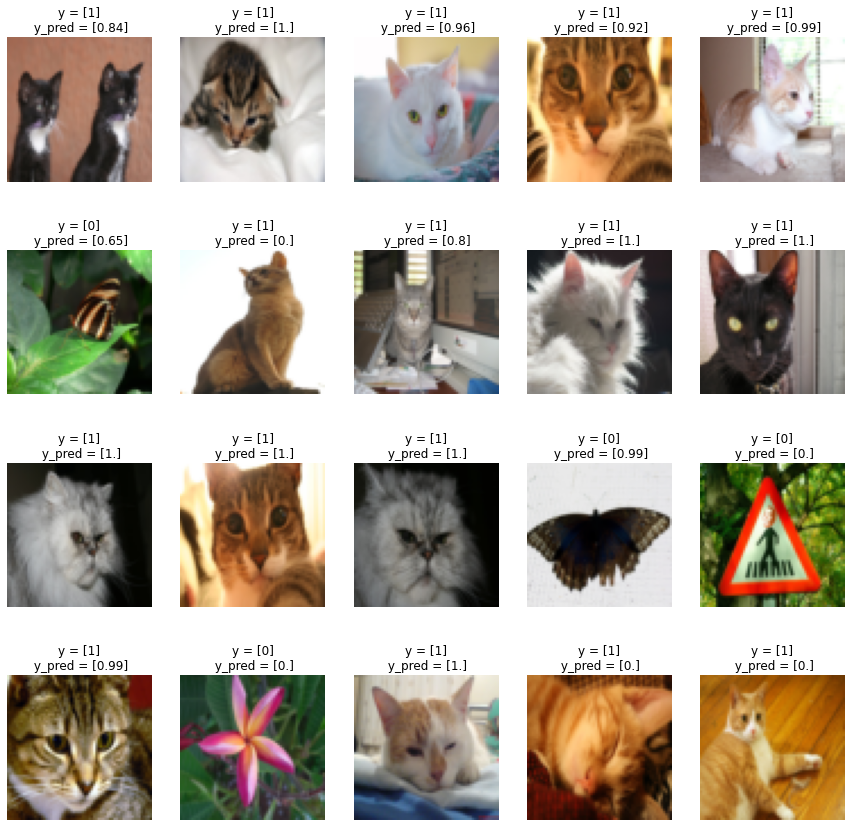

In [54]:
plt.figure(figsize=(15,15))
for i in range(20):
  plt.subplot(4,5,i+1)
  plt.imshow(X_test[i], cmap="Greys")
  y_pred = modelo.predict(test_x[i,:].reshape((1,-1)), verbose=0)
  plt.title("y = " + str(Y_test[i]) + "\n y_pred = " + str(np.round(y_pred[0],2)))
  plt.axis("off")

# **Reto**

Implementar una red neuronal profunda para realizar regresión sobre el [dataset de precios de casas en boston](http://lib.stat.cmu.edu/datasets/boston).

In [55]:
(X_train, Y_train), (X_test, Y_test) = datasets.boston_housing.load_data(path="boston_housing.npz")

print ("Tamaño de X_train: " + str(X_train.shape))
print ("Tamaño de Y_train: " + str(Y_train.shape))
print ("Tamaño de X_test: " + str(X_test.shape))
print ("Tamaño de Y_test: " + str(Y_test.shape))

Tamaño de X_train: (404, 13)
Tamaño de Y_train: (404,)
Tamaño de X_test: (102, 13)
Tamaño de Y_test: (102,)
